In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from jax.nn import sigmoid, log_sigmoid

import jax
from jax_advi.advi import optimize_advi_mean_field
from jax import jit
from jax.scipy.stats import norm

from advi_jax import ADVI
from advi_jax.init import initialize
from advi_jax.variational_distributions import MeanField
import distrax
import optax

In [2]:
N = 1000
K = 10

np.random.seed(2)

X = np.random.randn(N, K)
beta_true = np.random.randn(K)
gamma_true = np.random.normal()

logit_true = X @ beta_true + gamma_true

y = np.random.uniform(size=N) < sigmoid(logit_true)

In [3]:
# Try ADVI
theta_shapes = {
    'beta': (K),
    'gamma': ()
}

In [4]:
def calculate_likelihood(theta, X, y):
    
    logit_prob = X @ theta['beta'] + theta['gamma']
    
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    
    return jnp.sum(y * prob_pres + (1 - y) * prob_abs)

def calculate_prior(theta):
    
    beta_prior = jnp.sum(norm.logpdf(theta['beta']))
    gamma_prior = jnp.sum(norm.logpdf(theta['gamma']))
    
    return beta_prior + gamma_prior

In [5]:
from functools import partial

In [6]:
log_lik_fun = jit(partial(calculate_likelihood, X=X, y=y))
log_prior_fun = jit(calculate_prior)

In [7]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, log_lik_fun, n_draws=None)

In [8]:
# Get the ADVI draws
from jax_advi.advi import get_posterior_draws

draws = get_posterior_draws(result['free_means'], result['free_sds'], {}, n_draws=10000)

beta_means_advi = draws['beta'].mean(axis=0)
beta_sds_advi = draws['beta'].std(axis=0)

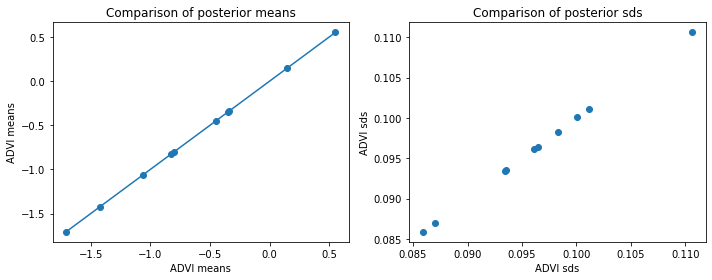

In [9]:
f, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].scatter(beta_means_advi, beta_means_advi)

ax[0].plot([beta_means_advi.min(), beta_means_advi.max()],
           [beta_means_advi.min(), beta_means_advi.max()])

ax[1].scatter(beta_sds_advi, beta_sds_advi)
# ax[1].plot([beta_sds_advi.min(), beta_sds_advi.max()],
#               [beta_sds_advi.min(), beta_sds_advi.max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('ADVI means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('ADVI sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison.png', dpi=300)

In [10]:
prior_dist = distrax.Normal(loc=jnp.zeros(K+1), scale=jnp.ones(K+1))

def likelihood_log_prob_one(sample, X, y):
    pred = jnp.sum(X * sample)
    prob = sigmoid(pred)
    return distrax.Bernoulli(probs=prob).log_prob(y)

def likelihood_log_prob_fun(sample, data, **params):
    X, y = data
    log_probs = jax.vmap(likelihood_log_prob_one, in_axes=(None, 0, 0))(sample, X, y)
#     print(log_probs, log_probs.sum())
    return log_probs.sum()

X_ = jnp.concatenate([jnp.ones((N,1)), X], axis=1)

data = (X_, y)

model = ADVI(prior_dist, likelihood_log_prob_fun, data)

In [11]:
def inference_loop(key, params, model, optimizer, n_iterations, n_samples):
    def one_step(carry, key):
        params, state, data = carry
        value, grads = model.value_and_grad_fun(key, params, data, n_samples)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state, data), value

    keys = jax.random.split(key, n_iterations)
    state = optimizer.init(params)
    carry = (params, state, model.data)
    one_step = jax.jit(one_step, static_argnums=2)
    (params, state, data), values = jax.lax.scan(one_step, carry, keys)

    return values, params

variational_dist = MeanField(u_mean=jnp.zeros((K+1, )), u_scale=jnp.zeros((K+1, )))

In [12]:
seed = 5
key = jax.random.PRNGKey(seed)
subkey = jax.random.PRNGKey(seed+1)

n_samples = 10
n_iterations=100
learning_rate = 0.1

# t_init = time()

params = {"variational_dist": variational_dist}
params = initialize(key, params)  # randomly initialize the parameters
print("initial params", params["variational_dist"])
optimizer = optax.adam(learning_rate=0.01)
model.value_and_grad_fun(subkey, params, data, n_samples=1)
# losses, params = inference_loop(subkey, params, model, optimizer, n_iterations, n_samples)
# print("final params", params["variational_dist"])
# print(f"{time()-t_init:.2f} seconds")
# plt.plot(losses);

initial params MeanField(u_mean=DeviceArray([-1.3006209 ,  1.1678952 ,  0.32451877, -0.70131886,
              0.9478563 ,  0.4991682 ,  1.0534693 , -0.12855814,
             -1.8437343 ,  1.0839263 , -0.20180629], dtype=float32), u_scale=DeviceArray([-0.91099036, -0.80072755,  1.3114007 ,  0.6532997 ,
             -0.46683976,  0.0310739 , -1.5269119 ,  1.0970311 ,
              0.19048469,  0.3184348 , -0.58450043], dtype=float32), bijector=<distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3462fcdd30>)


(DeviceArray(inf, dtype=float32),
 {'variational_dist': MeanField(u_mean=DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32), u_scale=DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32), bijector=<distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3462df5a00>)})

In [13]:
likelihood_log_prob_fun(variational_dist.sample(subkey), data)
variational_dist.sample_and_log_prob(subkey)

TypeError: '<' not supported between instances of 'tuple' and 'int'